In [7]:
pip install nba_api pandas numpy tensorflow matplotlib scikit-learn # Install Dependencies

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
Using cached requests-2.32.4-py3-none-any.whl (64 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.26.0
    Uninstalling requests-2.26.0:
      Successfully uninstalled requests-2.26.0
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see disc

In [56]:
# Import The Following Libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from nba_api.stats.endpoints import teamgamelog
from nba_api.stats.static import teams

In [58]:
# Get list of all NBA teams
nba_teams = teams.get_teams()

def fetch_all_teams_gamelogs(season):
    all_team_logs = []

    for team in nba_teams:
        team_id = team['id']
        try:
            gamelog = teamgamelog.TeamGameLog(team_id=team_id, season=season, season_type_all_star="Regular Season")
            df = gamelog.get_data_frames()[0]
            df['TEAM_ID'] = team_id
            df['SEASON'] = season
            all_team_logs.append(df)
            time.sleep(0.6)  # Prevent rate-limiting by NBA API
        except Exception as e:
            print(f"Failed for team {team['full_name']} ({team_id}): {e}")
    
    return pd.concat(all_team_logs, ignore_index=True)

# Fetch logs for both seasons
df_2023 = fetch_all_teams_gamelogs("2023-24")
df_2024 = fetch_all_teams_gamelogs("2024-25")

# Combine into one dataframe
df_all = pd.concat([df_2023, df_2024], ignore_index=True)

# Save locally (optional)
df_all.to_csv("nba_all_games_2023_2025.csv", index=False)

# Print out first 5 and last 20
df_all.head(-20)

,Team_ID,Game_ID,GAME_DATE,MATCHUP,WL,W,L,W_PCT,MIN,FGM,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,TEAM_ID,SEASON
0,1610612737,0022301188,"APR 14, 2024",ATL @ IND,L,36,46,0.439,240,39,...,23,32,25,6,5,15,12,115,1610612737,2023-24
1,1610612737,0022301178,"APR 12, 2024",ATL @ MIN,L,36,45,0.444,240,40,...,31,40,23,4,1,14,25,106,1610612737,2023-24
2,1610612737,0022301159,"APR 10, 2024",ATL vs. CHA,L,36,44,0.450,240,43,...,31,38,35,7,2,16,20,114,1610612737,2023-24
3,1610612737,0022301147,"APR 09, 2024",ATL vs. MIA,L,36,43,0.456,290,45,...,42,59,28,13,2,15,23,111,1610612737,2023-24
4,1610612737,0022301130,"APR 06, 2024",ATL @ DEN,L,36,42,0.462,240,37,...,27,38,30,8,2,16,18,110,1610612737,2023-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4895,1610612766,0022401212,"DEC 13, 2024",CHA @ CHI,L,7,18,0.280,240,35,...,37,54,22,7,5,16,20,95,1610612766,2024-25
4896,1610612766,0022400349,"DEC 08, 2024",CHA @ IND,W,7,17,0.292,240,40,...,35,45,24,11,3,24,18,113,1610612766,2024-25
4897,1610612766,0022400340,"DEC 07, 2024",CHA vs. CLE,L,6,17,0.261,240,37,...,27,37,21,6,5,10,27,102,1610612766,2024-25
4898,1610612766,0022400327,"DEC 05, 2024",CHA @ NYK,L,6,16,0.273,240,40,...,30,40,27,3,4,10,22,101,1610612766,2024-25


In [10]:
# Convert date
df_all['GAME_DATE'] = pd.to_datetime(df_all['GAME_DATE'])

# Sort
df_all = df_all.sort_values(by=['TEAM_ABBREVIATION', 'GAME_DATE'])

# Add binary target column
df_all['WIN'] = df_all['WL'].apply(lambda x: 1 if x == 'W' else 0)

# Add home/away
df_all['HOME'] = df_all['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# Add opponent points estimate (better than nothing for now)
print(df_all.columns)

# Features to use
df_all['DAYOFWEEK'] = df_all['GAME_DATE'].dt.dayofweek  # captures weekday/weekend patterns
df_all['MONTH'] = df_all['GAME_DATE'].dt.month
df_all['TEAM_CODE'] = df_all['TEAM_ABBREVIATION'].astype('category').cat.codes  # Encode team
features = ['PTS', 'REB', 'AST', 'FG_PCT', 'HOME', 'DAYOFWEEK', 'MONTH', 'TEAM_CODE']
target = 'WIN'

# Drop missing values
df_all = df_all.dropna(subset=features + [target])
print(df_all.to_string())

Index(['SEASON_YEAR', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS',
       'GP_RANK', 'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'FGM_RANK',
       'FGA_RANK', 'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK',
       'FTM_RANK', 'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK', 'DREB_RANK',
       'REB_RANK', 'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK', 'BLKA_RANK',
       'PF_RANK', 'PFD_RANK', 'PTS_RANK', 'PLUS_MINUS_RANK', 'AVAILABLE_FLAG',
       'WIN', 'HOME'],
      dtype='object')
     SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME     GAME_ID  GAME_DATE      MATCHUP WL   MIN  FGM  FGA  FG_PCT  FG3M  FG3A  FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB  REB  AST   TOV  STL  BLK  BLKA  PF  PFD  PTS  PLUS_MINUS  GP_RANK  W_RANK  L_RANK 

In [11]:
# Build Sequential Windows:
sequence_length = 10  # number of past games to use
team_data = []

for team in df_all['TEAM_ABBREVIATION'].unique():
    team_df = df_all[df_all['TEAM_ABBREVIATION'] == team]
    for i in range(len(team_df) - sequence_length):
        seq = team_df.iloc[i:i+sequence_length]
        label = team_df.iloc[i+sequence_length]['WIN']
        x = seq[['PTS', 'REB', 'AST', 'FG_PCT']].values
        team_data.append((x, label))

X, y = zip(*team_data)
X = np.array(X)
y = np.array(y)
print(X,y)

[[[110.     42.     24.      0.419]
  [120.     44.     28.      0.483]
  [127.     46.     32.      0.505]
  ...
  [120.     36.     22.      0.482]
  [109.     48.     23.      0.437]
  [126.     41.     28.      0.517]]

 [[120.     44.     28.      0.483]
  [127.     46.     32.      0.505]
  [127.     36.     28.      0.558]
  ...
  [109.     48.     23.      0.437]
  [126.     41.     28.      0.517]
  [114.     30.     28.      0.547]]

 [[127.     46.     32.      0.505]
  [127.     36.     28.      0.558]
  [130.     57.     26.      0.5  ]
  ...
  [126.     41.     28.      0.517]
  [114.     30.     28.      0.547]
  [116.     39.     24.      0.449]]

 ...

 [[103.     41.     21.      0.443]
  [104.     48.     24.      0.402]
  [119.     49.     30.      0.505]
  ...
  [ 97.     38.     16.      0.447]
  [ 90.     32.     21.      0.407]
  [ 98.     50.     18.      0.418]]

 [[104.     48.     24.      0.402]
  [119.     49.     30.      0.505]
  [109.     31.     19.   

In [12]:
# Normalize Features and Split

# Flatten for normalization
X_reshaped = X.reshape(-1, 4)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_reshaped).reshape(X.shape)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional

In [43]:
# Define and Train an RNN Model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(sequence_length, X.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(32)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Epoch 1/10


/usr/local/lib/python3.9/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.4988 - loss: 0.6952 - val_accuracy: 0.4838 - val_loss: 0.6940
Epoch 2/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5000 - loss: 0.6930 - val_accuracy: 0.5271 - val_loss: 0.6894
Epoch 3/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5315 - loss: 0.6919 - val_accuracy: 0.4892 - val_loss: 0.6925
Epoch 4/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5396 - loss: 0.6891 - val_accuracy: 0.4957 - val_loss: 0.6948
Epoch 5/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5528 - loss: 0.6866 - val_accuracy: 0.5801 - val_loss: 0.6854
Epoch 6/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5770 - loss: 0.6802 - val_accuracy: 0.5227 - val_loss: 0.6997
Epoch 7/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5660 - loss: 0.6817 - val_accuracy: 0.5649 - val_loss: 0.6857
Epoch 8/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5659 - loss: 0.6791 - val_accuracy: 0.5552 - 

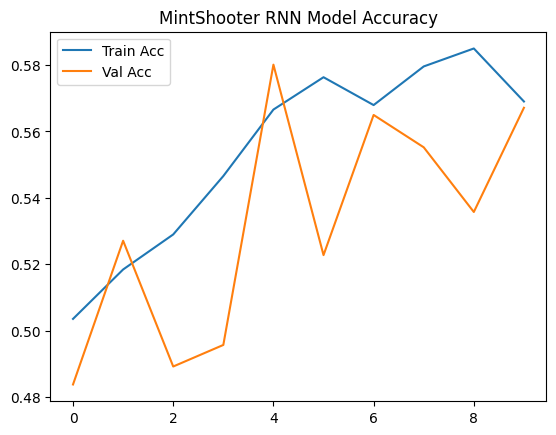

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5872 - loss: 0.6799
Test Accuracy: 0.57


In [44]:
# Evaluate the Model
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('MintShooter RNN Model Accuracy')
plt.show()

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

In [45]:
# Save the Model
model.save("models/MintShooter-RNN.keras")

In [46]:
# View Model Predictions

# Generate predictions (as probabilities)
y_pred_probs = model.predict(X_test)

# Convert to binary labels (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Show predictions vs actual
results_df = pd.DataFrame({
    'Predicted': y_pred,
    'Actual': y_test
})
print(results_df.head(20))

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
    Predicted  Actual
0           1       1
1           0       0
2           1       1
3           1       0
4           1       0
5           1       1
6           1       1
7           0       0
8           1       1
9           1       0
10          1       0
11          1       0
12          1       1
13          1       0
14          0       0
15          1       1
16          0       1
17          1       1
18          1       1
19          0       0


In [47]:
# Install Dependency for Testing
from sklearn.metrics import classification_report, confusion_matrix

In [48]:
# Generate Confusion Matrix For Accuracy Viewing
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.27      0.38       447
           1       0.55      0.85      0.67       477

    accuracy                           0.57       924
   macro avg       0.59      0.56      0.52       924
weighted avg       0.59      0.57      0.53       924

[[120 327]
 [ 73 404]]
